# Optimization Examples

In [1]:
# # Change path to project root
%cd ..

/home/amirhessam/Documents/GitHub/slick-ml


In [2]:
%load_ext autoreload

# widen the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# change the path and loading class
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# %autoreload
# from slickml.optimization import XGBoostHyperParamsTuner

In [36]:
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

class XGBoostHyperParamsTuner:
    """XGBoost Hyper-Parameters Tuner.
    This is wrapper using Bayesian Optimization to tune the parameters
    for XGBoost classifier using xgboost.cv() model with n-folds 
    cross-validation iteratively. This function is pretty useful find
    the optimized set of parameters before training. Please note that,
    the optimizier objective is always to maximize the target. Therefore,
    in case of using a metric such as logloss or error, the negative value
    of the metric will be maximized.
    Parameters
    ----------
    n_iter: int, optional (default=5)
        Number of iteration rounds for hyper-parameters tuning
    init_points: int, optional (default=5)
        Number of initial points to initialize the optimizer
    acq: str, optional (default="ei")
        Type of acquisition function such as expected improvement (ei)
    pbounds: dict, optional
        Set of parameters boundaries for Bayesian Optimization
        (default={"max_depth" : (2, 7),
                  "learning_rate" : (0, 1), 
                  "min_child_weight" : (1, 20),
                  "colsample_bytree": (0.1, 1.0)
                  "subsample" : (0.1, 1),
                  "gamma" : (0, 1),
                  "reg_alpha" : (0, 1),
                  "reg_lambda" : (0, 1)})    
    num_boost_round: int, optional (default=200)
        Number of boosting round at each fold of xgboost.cv()
    n_splits: int, optional (default=4)
        Number of folds for cross-validation
    metrics: str or tuple[str], optional (default=("auc"))
        Metric used for evaluation at cross-validation
        using xgboost.cv(). Please note that this is different
        than eval_metric that needs to be passed to params dict.
        Possible values are "auc", "aucpr", "error", "logloss"
    objective: str, optional (default="binary:logistic")
        Type of objective function for classification and regression
    early_stopping_rounds: int, optional (default=20)
        The criterion to early abort the xgboost.cv() phase
        if the test metric is not improved
    random_state: int, optional (default=1367)
        Random seed
    stratified: bool, optional (default=True)
        Flag to stratificaiton of the targets to run xgboost.cv() to
        find the best number of boosting round at each fold of
        each iteration
    shuffle: bool, optional (default=True)
        Flag to shuffle data to have the ability of building
        stratified folds in xgboost.cv()
    sparse_matrix: bool, optional (default=False)
        Flag to convert data to sparse matrix with csr format.
        This would increase the speed of feature selection for
        relatively large datasets
    scale_mean: bool, optional (default=False)
        Flag to center the data before scaling. This flag should be
        False when using sparse_matrix=True, since it centering the data
        would decrease the sparsity and in practice it does not make any
        sense to use sparse matrix method and it would make it worse.
    scale_std: bool, optional (default=False)
        Flag to scale the data to unit variance
        (or equivalently, unit standard deviation)
    show_stdv: bool, optional (default=False)
        Flag to show standard deviations in callbacks for
        xgboost.cv() results
    importance_type: str, optional (default="total_gain")
        Importance type of xgboost.train() with possible values
        "weight", "gain", "total_gain", "cover", "total_cover"
    verbose: bool, optional (default=True)
        Flag to show the Bayesian Optimization progress at each iteration
        
        
        
        
    Attributes
    ----------
    feature_importance_: dict()
        Returns a dict() of all feature importance based on
        importance_type at each fold of each iteration during
        selection process
    feature_frequency_: Pandas DataFrame()
        Returns a DataFrame() cosists of total frequency of
        each feature during the selection process
    cv_results_: Pandas DataFrame()
        Return a Pandas DataFrame() of the mean value of the metrics
        in n-folds cross-validation for each boosting round
    scaler_: StandardScaler object
        Returns the scaler object if any of scale_mean or scale_std
        was passed True.
    X_train_: Pandas DataFrame()
        Returns scaled training data set that passed if if any of
        scale_mean or scale_std was passed as True, else X_train.
    X_test_: Pandas DataFrame()
        Returns transformed testing data set using scaler_ object if if any of
        scale_mean or scale_std was passed as True, else X_train.
    d_train_: xgboost.DMatrix object
        Returns the xgboost.DMatrix(X_train_, y_train)
    d_test_: xgboost.DMatrix object
        Returns the xgboost.DMatrix(X_test_, y_test)
    shap_values_train_: Numpy array
        SHAP values from treeExplainer using X_train
    shap_values_test_: Numpy array
        SHAP values from treeExplainer using X_test
    fit(X_train, y_train): class method
        Returns None and applies the training process using
        the (X_train, y_train) set using xgboost.cv() and xgboost.train()
    predic_proba(X_test, y_test): class method
        Return the prediction probabilities for both classes. Please note that
        it only reports the probability of the positive class, while the sklearn
        one returns for both and slicing like pred_proba[:, 1]
        is needed for positive class predictions
    get_xgb_params(): class method
        Returns params dict
    get_feature_importance(): class method
        Returns feature importance based on importance_type
        at each fold of each iteration of the selection process
    get_feature_frequency(): class method
        Returns the total feature frequency of the bst model
        at each fold of each iteration of selection process
    get_cv_results(): class method
        Return a Pandas DataFrame() of the mean value of the metrics
        in n-folds cross-validation for each boosting round
    plot_cv_results(): class method
        Plot cross-validation results
    plot_feature_importance(): class method
        Plots feature importance
    plot_shap_summary(): class method
        Plot shap values summary
    """

    def __init__(
        self,
        n_iter=None,
        init_points=None,
        acq=None,
        pbounds=None,
        num_boost_round=None,
        n_splits=None,
        metrics=None,
        objective=None,
        early_stopping_rounds=None,
        random_state=None,
        stratified=True,
        shuffle=True,
        sparse_matrix=False,
        scale_mean=False,
        scale_std=False,
        importance_type=None,
        verbose=True,
    ):
        
        if n_iter is None:
            self.n_iter = 5
        else:
            if not isinstance(n_iter, int):
                raise TypeError("The input n_iter must have integer dtype.")
            else:
                self.n_iter = n_iter
                
        if init_points is None:
            self.init_points = 5
        else:
            if not isinstance(init_points, int):
                raise TypeError("The input init_points must have integer dtype.")
            else:
                self.init_points = init_points  
                
        if acq is None:
            self.acq = "ei"
        else:
            if not isinstance(acq, str):
                raise TypeError("The input acq must have str dtype.")
            else:
                self.acq = acq
                
        pbounds_ = {"max_depth" : (2, 7),
                    "learning_rate" : (0, 1),
                    "min_child_weight" : (1, 20),
                    "colsample_bytree": (0.1, 1.0),
                    "subsample" : (0.1, 1),
                    "gamma" : (0, 1),
                    "reg_alpha" : (0, 1),
                    "reg_lambda" : (0, 1)}
        if pbounds is None:
            self.pbounds = pbounds_
        else:
            if not isinstance(pbounds, dict):
                raise TypeError("The input pbounds must have dict dtype.")
            else:
                self.pbounds = pbounds_
                for key, val in pbounds.items():
                    self.pbounds[key] = val                

        if num_boost_round is None:
            self.num_boost_round = 200
        else:
            if not isinstance(num_boost_round, int):
                raise TypeError("The input num_boost_round must have integer dtype.")
            else:
                self.num_boost_round = num_boost_round

        if n_splits is None:
            self.n_splits = 4
        else:
            if not isinstance(n_splits, int):
                raise TypeError("The input n_splits must have integer dtype.")
            else:
                self.n_splits = n_splits

        if metrics is None:
            self.metrics = "auc"
        else:
            if not isinstance(metrics, str):
                raise TypeError("The input metrics must be a str dtype.")
            else:
                self.metrics = metrics
                
        if objective is None:
            self.objective = "binary:logistic"
        else:
            if not isinstance(objective, str):
                raise TypeError("The input objective must be a str dtype.")
            else:
                self.objective = objective                

        if early_stopping_rounds is None:
            self.early_stopping_rounds = 20
        else:
            if not isinstance(early_stopping_rounds, int):
                raise TypeError(
                    "The input early_stopping_rounds must have integer dtype."
                )
            else:
                self.early_stopping_rounds = early_stopping_rounds

        if random_state is None:
            self.random_state = 1367
        else:
            if not isinstance(random_state, int):
                raise TypeError("The input random_state must have integer dtype.")
            else:
                self.random_state = random_state

        if not isinstance(stratified, bool):
            raise TypeError("The input stratified must have bool dtype.")
        else:
            self.stratified = stratified

        if not isinstance(shuffle, bool):
            raise TypeError("The input shuffle must have bool dtype.")
        else:
            self.shuffle = shuffle

        if not isinstance(sparse_matrix, bool):
            raise TypeError("The input sparse_matrix must have bool dtype.")
        else:
            self.sparse_matrix = sparse_matrix

        if not isinstance(scale_mean, bool):
            raise TypeError("The input scale_mean must have bool dtype.")
        else:
            self.scale_mean = scale_mean

        if not isinstance(scale_std, bool):
            raise TypeError("The input scale_std must have bool dtype.")
        else:
            self.scale_std = scale_std

        if importance_type is None:
            self.importance_type = "total_gain"
        else:
            if not isinstance(importance_type, str):
                raise TypeError("The input importance_type must have str dtype.")
            else:
                if importance_type in [
                    "weight",
                    "gain",
                    "total_gain",
                    "cover",
                    "total_cover",
                ]:
                    self.importance_type = importance_type
                else:
                    raise ValueError("The input importance_type value is not valid.")

        if not isinstance(verbose, bool):
            raise TypeError("The input verbose must have bool dtype.")
        else:
            if verbose:
                self.verbose = 2
            else:
                self.verbose = 0
                
    def _dtrain(self, X_train, y_train):
        """
        Function to return dtrain matrix based on
        input parameters including sparse_matrix,
        and scaled using both numpy array and pandas
        DataFrame.
        Parameters
        ----------
        X_train: numpy.array or Pandas DataFrame
            Training features data
        y_train: numpy.array[int] or list[int]
            List of training ground truth binary values [0, 1]
        """
        if isinstance(X_train, np.ndarray):
            self.X_train = pd.DataFrame(
                X_train, columns=[f"F_{i}" for i in range(X_train.shape[1])]
            )
        elif isinstance(X_train, pd.DataFrame):
            self.X_train = X_train
        else:
            raise TypeError(
                "The input X_train must be numpy array or pandas DataFrame."
            )

        if isinstance(y_train, np.ndarray) or isinstance(y_train, list):
            self.y_train = y_train
        else:
            raise TypeError("The input y_train must be numpy array or list.")
        self.y_train = y_train

        if self.sparse_matrix and self.scale_mean:
            raise ValueError(
                "The scale_mean should be False in conjuction of using sparse_matrix=True."
            )

        if self.scale_mean or self.scale_std:
            self.scaler_ = StandardScaler(
                with_mean=self.scale_mean, with_std=self.scale_std
            )
            self.X_train_ = pd.DataFrame(
                self.scaler_.fit_transform(self.X_train),
                columns=self.X_train.columns.tolist(),
            )
        else:
            self.X_train_ = self.X_train.copy()

        if not self.sparse_matrix:
            dtrain = xgb.DMatrix(data=self.X_train_, label=self.y_train)
        else:
            dtrain = xgb.DMatrix(
                data=df_to_csr(self.X_train_, fillna=0.0, verbose=False),
                label=self.y_train,
                feature_names=self.X_train_.columns.tolist(),
            )

        return dtrain
    
    def fit(self, X_train, y_train):
        """
        Function to run xgboost.cv() method first to find the best number of boosting round
        and train a model based on that on (X_train, y_train) set and returns it.
        """

        # helper function for xgboost eval
        def _xgb_eval(max_depth,
                      subsample,
                      colsample_bytree,
                      min_child_weight,
                      learning_rate,
                      gamma,
                      reg_alpha,
                      reg_lambda):
            """
            Helper Function to eval bayesian optimization
            """
            params = {"eval_metric" : "auc",
                  "tree_method": "hist",
                  "objective" : self.objective,
                  "max_delta_step": 1,
                  "silent" : True,
                  "nthread" : 4,
                  "scale_pos_weight" : 1,
                  "reg_alpha" : reg_alpha,
                  "reg_lambda" : reg_lambda,
                  "learning_rate" : learning_rate,
                  "max_depth": int(max_depth),
                  "min_child_weight": min_child_weight,
                  "gamma" : gamma,
                  "subsample" : subsample,
                  "colsample_bytree" : colsample_bytree}
            
            cv_result = xgb.cv(params = params,
                               dtrain = self.dtrain_,
                               num_boost_round = self.num_boost_round,
                               nfold = self.n_splits,
                               stratified = self.stratified,
                               metrics = self.metrics,
                               early_stopping_rounds = self.early_stopping_rounds,
                               seed = self.random_state,
                               shuffle = True)
            
            # set to return + or - results based on metric for maximization
            if self.metrics in ["logloss", "error"]:
                return (-1) * cv_result.iloc[-1][2]
            else:
                return cv_result.iloc[-1][2]
        
        # creating dtrain
        self.dtrain_ = self._dtrain(X_train, y_train)
        
        # xgb_bo definition
        self.optimizer_ = BayesianOptimization(f=_xgb_eval,
                                               pbounds=self.pbounds,
                                               random_state=self.random_state,
                                               verbose=self.verbose)
        
        # maximizing xgb_bo
        self.optimizer_.maximize(init_points=self.init_points,
                        n_iter=self.n_iter,
                        acq=self.acq)
        
        # initiate the results
        self.optimization_results_ = self.get_optimization_results()
        
        # initiate the best params
        self.best_params_ = self.get_best_params()
        
        # initiate the best performance
        self.best_performance_ = self.get_best_performance()
        
        return None
    
    def get_pbounds(self):
        """
        Function to return the hyper-parameters bounds.
        """

        return self.pbounds
    
    def get_optimizer(self):
        """
        Function to return the Bayesian Optimization object.
        """

        return self.optimizer_    
    

    def get_optimization_results(self):
        """
        Function to return the optimization results.
        """
        frames = []
        for idx, res in enumerate(self.optimizer_.res):
            d = res["params"]
            d[self.metrics] = res["target"]
            frames.append(pd.DataFrame(data=d, index=[idx]))
            
        df_res = pd.concat(frames)

        return df_res
    
    def get_best_params(self):
        """
        Function to return the best (tuned) set of hyper-parameters.
        """
        targets = []
        for i, rs in enumerate(self.optimizer_.res):
            targets.append(rs["target"])
            
        best_params = self.optimizer_.res[targets.index(max(targets))]["params"]
        best_params["max_depth"] = int(best_params["max_depth"])
        
        return best_params
    
    def get_best_performance(self):
        """
        Function to return the performance of the best (tuned)
        set of hyper-parameters.
        """
        best_performance = self.optimization_results_.loc[self.optimization_results_[self.metrics] == self.optimization_results_[self.metrics].max(), :]
        best_performance.reset_index(drop=True, inplace=True)
        
        return best_performance
         

In [37]:
xbo = XGBoostHyperParamsTuner()

In [38]:
xbo.fit(X_train, y_train)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8245   |  0.8975   |  0.04571  |  0.6628   |  4.238    |  1.436    |  0.3064   |  0.7136   |  0.1931   |
|  2        |  0.8374   |  0.7904   |  0.6447   |  0.9152   |  3.334    |  3.238    |  0.7772   |  0.269    |  0.9726   |
|  3        |  0.8199   |  0.8498   |  0.6044   |  0.6874   |  6.651    |  15.7     |  0.061    |  0.5114   |  0.6848   |
|  4        |  0.8551   |  0.7297   |  0.8513   |  0.4627   |  4.757    |  4.965    |  0.9328   |  0.363    |  0.9365   |
|  5        |  0.8173   |  0.5425   |  0.5451   |  0.8782   |  6.633    |  5.028    |  0.1845   |  0.333    |  0.9125   |
|  6        |  0.8099   |  0.4336   |  0.282    |  0.3017   |  4.288    |  16.0     |  0.06196  |  0.8237   |  0.8923   |
|  7        |  0.8386   

In [39]:
xbo.get_best_params()

{'colsample_bytree': 0.8213916662259918,
 'gamma': 1.0,
 'learning_rate': 0.23148232373451072,
 'max_depth': 4,
 'min_child_weight': 5.632602921054691,
 'reg_alpha': 1.0,
 'reg_lambda': 0.39468801734425263,
 'subsample': 1.0}

In [40]:
xbo.get_best_performance()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,auc
0,0.821392,1.0,0.231482,4.570813,5.632603,1.0,0.394688,1.0,0.864417


In [41]:
xbo.best_performance_

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,auc
0,0.821392,1.0,0.231482,4.570813,5.632603,1.0,0.394688,1.0,0.864417


In [24]:
xbo.optimizer_

In [25]:
xbo.optimization_results_

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,auc
0,0.897530,0.045712,0.662807,4.238468,1.435660,0.306424,0.713585,0.193055,0.824512
1,0.790404,0.644709,0.915190,3.334492,3.238280,0.777161,0.269010,0.972576,0.837449
2,0.849819,0.604370,0.687435,6.651023,15.698338,0.061001,0.511379,0.684811,0.819881
3,0.729727,0.851274,0.462704,4.756996,4.964748,0.932765,0.362983,0.936539,0.855133
4,0.542456,0.545092,0.878165,6.632704,5.028311,0.184497,0.333049,0.912511,0.817250
5,0.433647,0.281979,0.301710,4.287809,15.997975,0.061965,0.823726,0.892268,0.809917
6,0.527662,0.710147,0.316749,2.901123,9.435776,0.691293,0.125812,0.646834,0.838585
7,0.129065,0.224998,0.896721,6.215583,3.885759,0.509329,0.256423,0.391094,0.807489
8,0.784692,0.884516,0.463588,4.454321,4.869008,0.969036,0.362743,0.979997,0.854646
9,0.821392,1.000000,0.231482,4.570813,5.632603,1.000000,0.394688,1.000000,0.864417


In [26]:
xbo.get_optimization_results()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,auc
0,0.897530,0.045712,0.662807,4.238468,1.435660,0.306424,0.713585,0.193055,0.824512
1,0.790404,0.644709,0.915190,3.334492,3.238280,0.777161,0.269010,0.972576,0.837449
2,0.849819,0.604370,0.687435,6.651023,15.698338,0.061001,0.511379,0.684811,0.819881
3,0.729727,0.851274,0.462704,4.756996,4.964748,0.932765,0.362983,0.936539,0.855133
4,0.542456,0.545092,0.878165,6.632704,5.028311,0.184497,0.333049,0.912511,0.817250
5,0.433647,0.281979,0.301710,4.287809,15.997975,0.061965,0.823726,0.892268,0.809917
6,0.527662,0.710147,0.316749,2.901123,9.435776,0.691293,0.125812,0.646834,0.838585
7,0.129065,0.224998,0.896721,6.215583,3.885759,0.509329,0.256423,0.391094,0.807489
8,0.784692,0.884516,0.463588,4.454321,4.869008,0.969036,0.362743,0.979997,0.854646
9,0.821392,1.000000,0.231482,4.570813,5.632603,1.000000,0.394688,1.000000,0.864417


In [27]:
xbo.get_optimizer()

In [28]:
xbo.get_pbounds()

{'max_depth': (2, 7),
 'learning_rate': (0, 1),
 'min_child_weight': (1, 20),
 'colsample_bytree': (0.1, 1.0),
 'subsample': (0.1, 1),
 'gamma': (0, 1),
 'reg_alpha': (0, 1),
 'reg_lambda': (0, 1)}

In [ ]:
XGBoostHyperParamsTuner()

# XGBoostHyperParamsTuner

## Example 1

In [4]:
# loading data
df = pd.read_csv("data/dummy_data.csv")
df.head()

,F1,F2,F3,F4,F5,F6,CLASS
0,5.7,4.7,3.7,58.0,249.30,456.47,0
1,7.7,6.6,4.1,20.0,260.92,443.43,1
2,6.2,4.3,4.6,59.0,255.63,478.96,1
3,5.7,4.4,3.8,49.0,195.28,381.94,0
4,9.1,4.7,4.6,17.0,259.55,395.67,1


In [5]:
# define X, y
y = df.CLASS.values
X = df.drop(["CLASS"], axis=1)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1367)

In [16]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
warnings.simplefilter("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline

def _my_bayesian_optimization(X, Y, n_iter = 5,
                                       init_points = 5,
                                       acq = "ei",
                                       num_boost_round = 1000,
                                       nfold = 10,
                                       stratified = True,
                                       metrics = ("auc"),
                                       early_stopping_rounds = 20,
                                       seed = 1367,
                                       shuffle = True,
                                       show_stdv = False,
                                       pbounds = None,
                                       importance_type = "total_gain",
                                       callbacks = False,
                                       verbose_eval = False):
    """
    a function to run bayesian optimization for xgboost
    input parameters:
                    X: features (pandas dataframe or numpy array)
                    Y: targets (1D array or list)
                    n_iter: total number of bayesian iterations (default = 5)
                    init_points: total initial points of optimization (default = 5)
                    acq
                    num_boost_rounds: max number of boosting rounds, (default = 1000)
                    stratified: stratificaiton of the targets (default = True)
                    metrics: classification/regression metrics (default = ("auc))
                    early_stopping_rounds: the criteria for stopping if the test metric is not improved (default = 20)
                    seed: random seed (default = 1367)
                    shuffle: shuffling the data (default = True)
                    show_stdv = showing standard deviation of cv results (default = False)
                    pbounds = set of parameters for bayesian optimization of xgboost cv
                            (default_params = {
                                               "eval_metric" : "auc",
                                               "tree_method": "hist",
                                               "objective" : "binary:logistic",
                                               "learning_rate" : 0.05,
                                               "max_depth": 2,
                                               "min_child_weight": 1,
                                               "gamma" : 0.0,
                                               "reg_alpha" : 0.0,
                                               "reg_lambda" : 1.0,
                                               "subsample" : 0.9,
                                               "max_delta_step": 1,
                                               "silent" : 1,
                                               "nthread" : 4,
                                               "scale_pos_weight" : 1
                                               }
                            )
                    importance_type = importance type of xgboost as string (default = "total_gain")
                                      the other options will be "weight", "gain", "cover", and "total_cover"
                    callbacks = printing callbacks for xgboost cv
                                (defaults = False, if True: [xgb.callback.print_evaluation(show_stdv = show_stdv),
                                                             xgb.callback.early_stop(early_stopping_rounds)])
                    verbose_eval : a flag to show the result during train on train/test sets (default = False)
    outputs:
            df_res: the parameters related to the best performance
            xgb_params: a dictionary of the best parameters of xgboost                
    
    
    """

    
    # callback flag
    if(callbacks == True):
        callbacks = [xgb.callback.print_evaluation(show_stdv = show_stdv),
                     xgb.callback.early_stop(early_stopping_rounds)]
    else:
        callbacks = None    
    
    # pbounds
    default_pbounds = {"max_depth" : (2, 5),
                       "learning_rate" : (0, 1), 
                       "min_child_weight" : (1, 20),
                       "subsample" : (0.1, 1),
                       "gamma": (0, 1),
                       "colsample_bytree": (0.1, 1.0)
                      }
    
    # updating the default parameters of the pbounds
    if pbounds is not None:
        for key, val in pbounds.items():
            default_pbounds[key] = val
    
    
    def __xgb_eval(learning_rate,
                   max_depth,
                   gamma,
                   colsample_bytree,
                   min_child_weight,
                   subsample):

        params = {"eval_metric" : "auc",
                  "tree_method": "hist",
                  "objective" : "binary:logistic",
                  "max_delta_step": 1,
                  "silent" : 1,
                  "nthread" : 4,
                  "scale_pos_weight" : 1,
                  "reg_alpha" : 0.0,
                  "reg_lambda" : 1.0,
                  "learning_rate" : learning_rate,
                  "max_depth": int(max_depth),
                  "min_child_weight": min_child_weight,
                  "gamma" : gamma,
                  "subsample" : subsample,
                  "colsample_bytree" : colsample_bytree 
                 }
        dtrain = xgb.DMatrix(data = X, label = Y)
        cv_result = xgb.cv(params = params,
                           dtrain = dtrain,
                           num_boost_round = num_boost_round,
                           nfold = nfold,
                           stratified = stratified,
                           metrics = metrics,
                           early_stopping_rounds = early_stopping_rounds,
                           seed = seed,
                           verbose_eval = verbose_eval,
                           shuffle = shuffle,
                           callbacks = callbacks)

        return cv_result.iloc[-1][2]
    

    xgb_bo = bo(__xgb_eval, default_pbounds, random_state = seed, verbose = 3)
    xgb_bo.maximize(init_points = init_points, n_iter = n_iter, acq = acq)
    
    
    targets = []
    for i, rs in enumerate(xgb_bo.res):
        targets.append(rs["target"])
    best_params = xgb_bo.res[targets.index(max(targets))]["params"]
    best_params["max_depth"] = int(best_params["max_depth"])
    
    xgb_params = {"eval_metric" : "auc",
                  "tree_method": "hist",
                  "objective" : "binary:logistic",
                  "max_delta_step": 1,
                  "silent" : 1,
                  "nthread" : 4,
                  "scale_pos_weight" : 1,
                  "reg_alpha" : 0.0,
                  "reg_lambda" : 1.0,
                  "learning_rate" : 0.05,
                  "max_depth": 2,
                  "min_child_weight": 5,
                  "gamma" : 0.0,
                  "subsample" : 1.0,
                  "colsample_bytree" : 0.9 
                 }
    for key, val in best_params.items():
        xgb_params[key] = val
    
    dtrain = xgb.DMatrix(data = X, label = Y)
    bst = xgb.train(params = xgb_params,
                    dtrain = dtrain,
                    num_boost_round = num_boost_round)
    
    # build results dataframe
    frames = []
    for idx, res in enumerate(xgb_bo.res):
        d = res['params']
        d[metrics] = res["target"]
        frames.append(pd.DataFrame(data = d, index = [idx]))
    
    res_df = pd.concat(frames)
   
    print(F"-*-*-*-*-*-* Optimization Results -*-*-*-*-*-*")
    display(res_df)
    
    # Plotting
    import matplotlib as mpl

    mpl.rcParams['axes.linewidth'] = 3 
    mpl.rcParams['lines.linewidth'] = 3
    cols = [col for col in res_df.columns.tolist() if col != "auc"]
    ip = 1
    plt.figure(figsize = (22, 10))
    colors = ["navy", "lavender", "lightblue", "cyan", "cadetblue", "slateblue"]
    for col in cols:
        res_df.sort_values(by = col, inplace=True)
        plt.subplot(2,3,ip)
        plt.plot(res_df.loc[:, col], res_df.loc[:, metrics], color = colors[ip-1])
        plt.xlabel(F"{col}", fontsize = 20)
        plt.ylabel(F"{metrics}", fontsize = 20)
        plt.tick_params(axis='both', which='major', labelsize = 12)
        ip += 1
    plt.show()
    
    print(F"-*-*-*-*-*-* Best Performance -*-*-*-*-*-*")
    display(res_df.loc[res_df[metrics] == res_df[metrics].max(), :])
    
    from xgboost import plot_importance
    from pylab import rcParams
    rcParams['figure.figsize'] = (10,10)
    plot_importance(bst, importance_type = importance_type, color = "skyblue", xlabel = importance_type)
    plt.show()   
    
    return res_df, xgb_params

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.8399   |  0.8975   |  0.04571  |  0.6628   |  3.343    |  1.436    |  0.3758   |
|  2        |  0.6255   |  0.7422   |  0.1034   |  0.7671   |  3.934    |  18.39    |  0.3402   |
|  3        |  0.7979   |  0.206    |  0.7772   |  0.269    |  4.909    |  16.83    |  0.6439   |
|  4        |  0.8223   |  0.7187   |  0.9302   |  0.7736   |  2.183    |  10.72    |  0.6848   |
|  5        |  0.8649   |  0.7297   |  0.8513   |  0.4627   |  3.654    |  4.965    |  0.9395   |
|  6        |  0.8401   |  0.9904   |  0.4464   |  0.2999   |  3.183    |  3.471    |  0.2568   |
|  7        |  0.8284   |  0.4362   |  0.7608   |  0.9427   |  4.16     |  4.092    |  1.0      |
|  8        |  0.5      |  1.0      |  0.6809   |  0.0      |  2.631    |  5.514    |  0.8435   |
|  9        |  0.818

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,auc
0,0.897530,0.045712,0.662807,3.343081,1.435660,0.375782,0.839867
1,0.742226,0.103395,0.767115,3.934126,18.388615,0.340209,0.625540
2,0.206024,0.777161,0.269010,4.908585,16.829513,0.643933,0.797949
3,0.718692,0.930205,0.773597,2.183002,10.716203,0.684811,0.822334
4,0.729727,0.851274,0.462704,3.654198,4.964748,0.939488,0.864922
5,0.990394,0.446359,0.299893,3.182505,3.471016,0.256754,0.840059
6,0.436156,0.760788,0.942745,4.160307,4.092312,1.000000,0.828377
7,1.000000,0.680885,0.000000,2.631088,5.513945,0.843542,0.500000
8,0.790540,0.344002,0.317325,3.236982,3.623004,0.168478,0.818017
9,0.678969,0.913986,0.597427,3.996444,4.713421,0.938649,0.863745


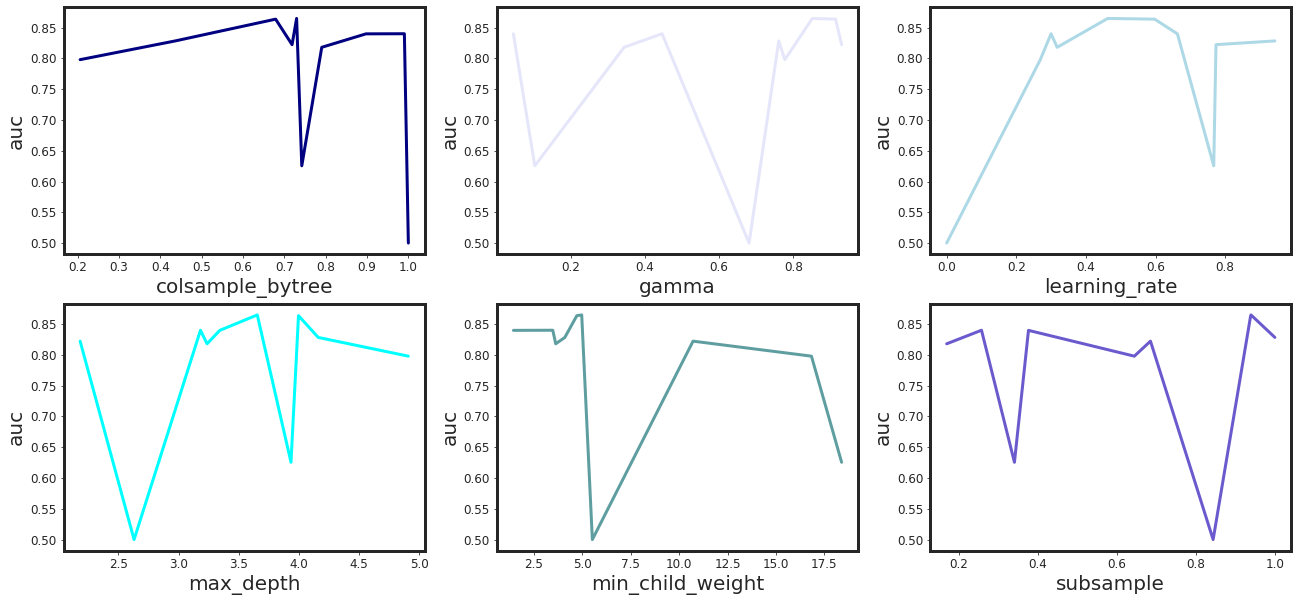

-*-*-*-*-*-* Best Performance -*-*-*-*-*-*


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,auc
4,0.729727,0.851274,0.462704,3.654198,4.964748,0.939488,0.864922


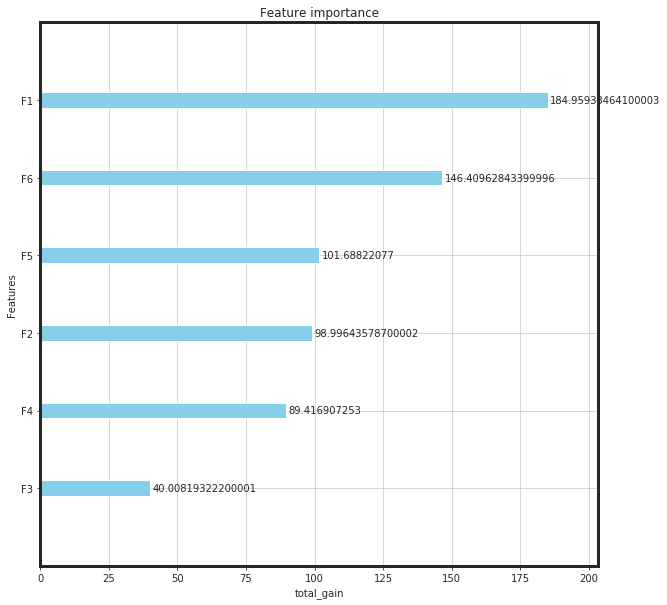

In [17]:
df_res, params = _my_bayesian_optimization(X_train, y_train)

In [11]:
from bayes_opt import BayesianOptimization

In [ ]:
BayesianOptimization()

In [6]:
# setup feature selector object
params={"eval_metric" : "auc",
        "learning_rate" : 0.05,
        "max_depth": 2,
        "min_child_weight" : 1,
        "gamma" : 0.0}

clf = XGBoostCVClassifier(num_boost_round=500,
                          n_splits=4,
                          metrics=("logloss"),
                          params=params)
clf.fit(X_train, y_train)

*-* Best Boosting Round = 191 -*- 4-Folds CV LOGLOSS: Train = 0.232 +/- 0.008 -*- Test = 0.320 +/- 0.025 *-*


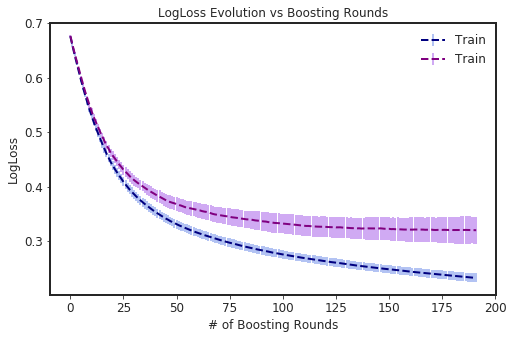

In [7]:
clf.plot_cv_results()

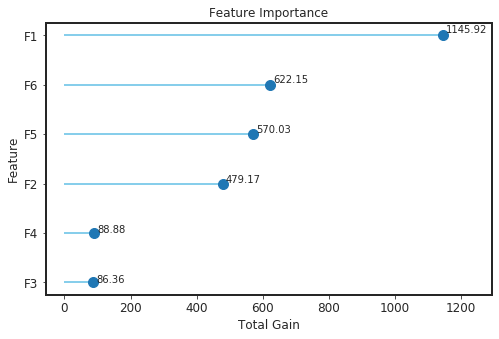

In [8]:
clf.plot_feature_importance()

In [9]:
# predic proba (or clf.predict_proba_)
pred_proba = clf.predict_proba(X_test, y_test)
pred_proba[:10]

array([0.6872404 , 0.6437372 , 0.9898107 , 0.91745585, 0.8029401 ,
       0.79498386, 0.6696425 , 0.9213432 , 0.9763105 , 0.9957327 ],
      dtype=float32)

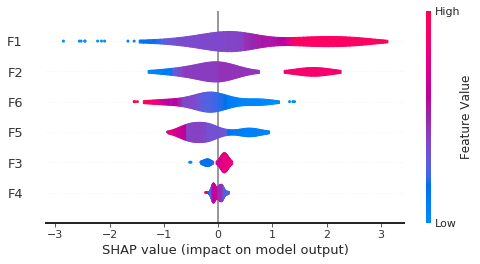

In [17]:
clf.plot_shap_summary(plot_type="violin")

In [12]:
clf.shap_values_test_[:10]

array([[-1.17578661e+00, -5.86567044e-01,  2.24011347e-01,
         1.57289244e-02,  5.16849458e-01,  1.82012349e-01],
       [ 2.63391405e-01, -6.70697689e-01, -3.13290775e-01,
        -2.99329627e-02, -1.77391380e-01, -9.14573073e-02],
       [ 1.92844176e+00,  1.65123546e+00,  6.71078265e-02,
        -1.91674568e-04, -4.64400291e-01, -2.17012703e-01],
       [ 1.73300028e+00,  5.55277169e-02,  7.87695572e-02,
         7.93843195e-02, -5.03318131e-01, -6.46094084e-01],
       [-8.95560607e-02, -1.23228216e+00, -3.07602823e-01,
        -7.56613836e-02,  5.68822742e-01,  9.30051088e-01],
       [ 2.82156050e-01, -1.97538398e-02, -2.15325534e-01,
         6.93768915e-03, -1.98684931e-01, -1.11096114e-01],
       [ 2.41128638e-01, -9.37509894e-01,  1.55264497e-01,
        -3.11029796e-03, -2.40322769e-01, -1.19882606e-01],
       [ 3.48925084e-01,  6.94350719e-01,  7.06390738e-02,
         5.83638158e-03, -1.72579139e-01, -9.74345058e-02],
       [ 2.96836704e-01,  1.69714773e+00,  1.374

In [13]:
clf.shap_values_train_[:10]

array([[ 1.6810727 ,  1.8670248 , -0.12494415, -0.11206084, -0.5291322 ,
        -0.4470591 ],
       [ 0.20235999, -0.23255867,  0.05476505,  0.06951104, -0.21339028,
        -0.4764193 ],
       [ 0.15221135, -1.1012809 , -0.32120004,  0.01052977,  0.04009805,
         0.23228301],
       [ 2.3585417 ,  1.646324  ,  0.06655529, -0.08806157, -0.11101343,
         0.0118833 ],
       [ 2.3252146 ,  0.07344273,  0.06707823,  0.1696119 , -0.47139165,
        -1.3900161 ],
       [ 1.6970465 ,  1.8670248 , -0.12494415, -0.07160836, -0.5291322 ,
        -0.4470591 ],
       [ 1.6877612 ,  0.63464016,  0.06441025, -0.0825933 , -0.2945922 ,
        -0.23303552],
       [ 0.25127745,  0.03300017,  0.15304364, -0.10549548, -0.1993008 ,
         0.8770816 ],
       [ 0.12158564, -0.06782506,  0.08321874,  0.01529711,  0.55117816,
         0.2280842 ],
       [ 0.18574946, -1.0985618 ,  0.1552645 ,  0.02025529, -0.2360702 ,
        -0.43954518]], dtype=float32)

In [14]:
# cv_results (or clf.cv_results_)
cvr = clf.get_cv_results()
cvr.tail()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
187,0.233434,0.008174,0.320090,0.025060
188,0.233021,0.008195,0.320024,0.024866
189,0.232621,0.008224,0.320062,0.024701
190,0.232216,0.008193,0.319890,0.024903
191,0.231895,0.008241,0.319651,0.024945


In [15]:
# feature importance (or clf.feature_importance_)
clf.get_feature_importance()

,feature,total_gain
0,F1,1145.921151
1,F6,622.148287
2,F5,570.030153
3,F2,479.170822
4,F4,88.880518
5,F3,86.359118
